In [ ]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromosome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [ ]:
# setting up the problem
target = 'Genetic Algorithm'    #最终目标
u_case = [chr(x) for x in range(65, 91)]    #大写字母
l_case = [chr(x) for x in range(97, 123)]   #小写字母
gene_pool = u_case + l_case + [' '] # 基因库: all English chracters and white space

# 初始化种群
def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  种群中个题数
        gene_pool   :  基因库
        state_length:  每个个体的基因长度
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['UPWrSoBXsJ pyBThI',
 'lVhvhBwCj HZUKXaP',
 'np UWzfxpflzPSdQ ',
 'beMLmXzlzqtehhymd',
 'lA eBlmoXRuuhAYOz',
 'dStEkfgaUGsNPrPfN',
 'TOqPqXHPHjfDviarj',
 'InqmXaRGoCVWFCmnZ',
 'eMVPgJkaATWePxtby',
 'AyFpuhxAtVKDkSZnd']

In [ ]:
def fitness_fn(sample):
    fitness = 0
    for i in range(len(sample)):
        if sample[i] == target[i]:
            fitness += 1
    return fitness

# test
fit = [fitness_fn(x) for x in init_pop]
print(fit)
sum(fit)

[1, 0, 0, 1, 1, 0, 1, 0, 2, 0]


6

In [ ]:
import random
def select(r, population, fitness_fn):
    """
    select *r* samples from *population*通常来说r=2
    挑选原则(加权随机/轮盘赌算法):the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    parents = []
    for _ in range(r):
        best = max(population,key=fitness_fn)
        parents.append(best)
        population.remove(best)
    return parents

# test
parents = select(2, init_pop, fitness_fn)
parents

['eMVPgJkaATWePxtby', 'UPWrSoBXsJ pyBThI']

In [ ]:
def recombine(x, y):
    """
    combine two parents to produce an offspring
    """
    r = random.randint(0,len(target) - 1)
    x_temp = x[r:]
    y_temp = y[r:]
    x = x[:r] + y_temp
    y = y[:r] + x_temp
    return max((x,y),key=fitness_fn)

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'eMVPgJkaATWePxtbI'

In [ ]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet, max_population):
        """
        max_population  :  种群中个体数
        alphabet   :  基因库
        target:  目标演化方向
        max_fitness: 最大适应度
        """
        self.target = target
        self.alphabet = alphabet
        self.max_fitness = len(target)
        self.max_population = max_population

    def init_population(self, pop_size):
        population = []
        for _ in range(pop_size):
            new_individual = "".join(random.choices(self.alphabet, k=len(self.target)))
            population.append(new_individual)

        return population

    def fitness(self, sample):
        # evaluate how close *sample* is to the target\
        fitness = 0
        for i in range(len(sample)):
            if sample[i] == self.target[i]:
                fitness += 1
        return fitness
    
    def reproduce(self, population, mutation_rate):
        """
        generate the next generation of population

        hint: make a new individual with 
        
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        new_population = []
        temp_parents = []
        for _ in range(int(self.max_population/2)):
            parents = self.select(2,population)
            temp_parents += parents
            child = self.mutate(self.recombine(*parents), self.alphabet, mutation_rate)
            new_population.append(child)
        population += temp_parents
        return new_population
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        next_population = []

        for _ in range(int(self.max_population/2)):
            best = max(old, key=self.fitness)
            next_population.append(best)
            old.remove(best)
        next_population += new

        return next_population


    def select(self,r, population):
        """
        select *r* samples from *population*通常来说r=2
        挑选原则(加权随机/轮盘赌算法/最优原则):the simplest choice is to sample from *population* with each individual weighted by its fitness
        """
        parents = []
        for _ in range(r):
            best = max(population,key=self.fitness)
            parents.append(best)
            population.remove(best)
        return parents


    def recombine(self, x, y):
        """
        combine two parents to produce an offspring
        """
        r = random.randint(0,len(x) - 1)
        x_temp = x[r:]
        y_temp = y[r:]
        x = x[:r] + y_temp
        y = y[:r] + x_temp
        return max((x,y),key=self.fitness)

    def mutate(self, x, gene_pool, pmut):
        """
        apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
        """
        if random.uniform(0, 1) >= pmut:
            return x
        n = len(x)
        g = len(gene_pool)
        c = random.randrange(0, n)
        r = random.randrange(0, g)

        new_gene = gene_pool[r]
        return x[:c] + new_gene + x[c + 1:]

def genetic_algorithm(problem: GAProblem, ngen, n_init_size, mutation_rate, log_intervel=10):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
            if best == problem.target:
                break
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [ ]:
# now set up the parameters
ngen = 1200
max_population = 120
mutation_rate = 0.3

sid = 12012711
target = f"Genetic Algorithm by {sid}" 
alphabet = [chr(x) for x in range(65, 91)] + [chr(x) for x in range(97, 123)] + [chr(x) for x in range(48,58)] + [' ']

problem = PhraseGeneration(target, alphabet, max_population)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/1200,	Best: 49YAUO0mooJZWRtJfrUU  1oMZjhE,	Fitness=2
Generation: 100/1200,	Best: jenet2czAlgorithm oy zu012p11,	Fitness=22
Generation: 200/1200,	Best: Genetic Algorithm by zu012p11,	Fitness=26
Generation: 300/1200,	Best: Genetic Algorithm by z2012p11,	Fitness=27
Generation: 400/1200,	Best: Genetic Algorithm by z2012p11,	Fitness=27
Generation: 500/1200,	Best: Genetic Algorithm by 12012p11,	Fitness=28
Generation: 600/1200,	Best: Genetic Algorithm by 12012711,	Fitness=29


'Genetic Algorithm by 12012711'

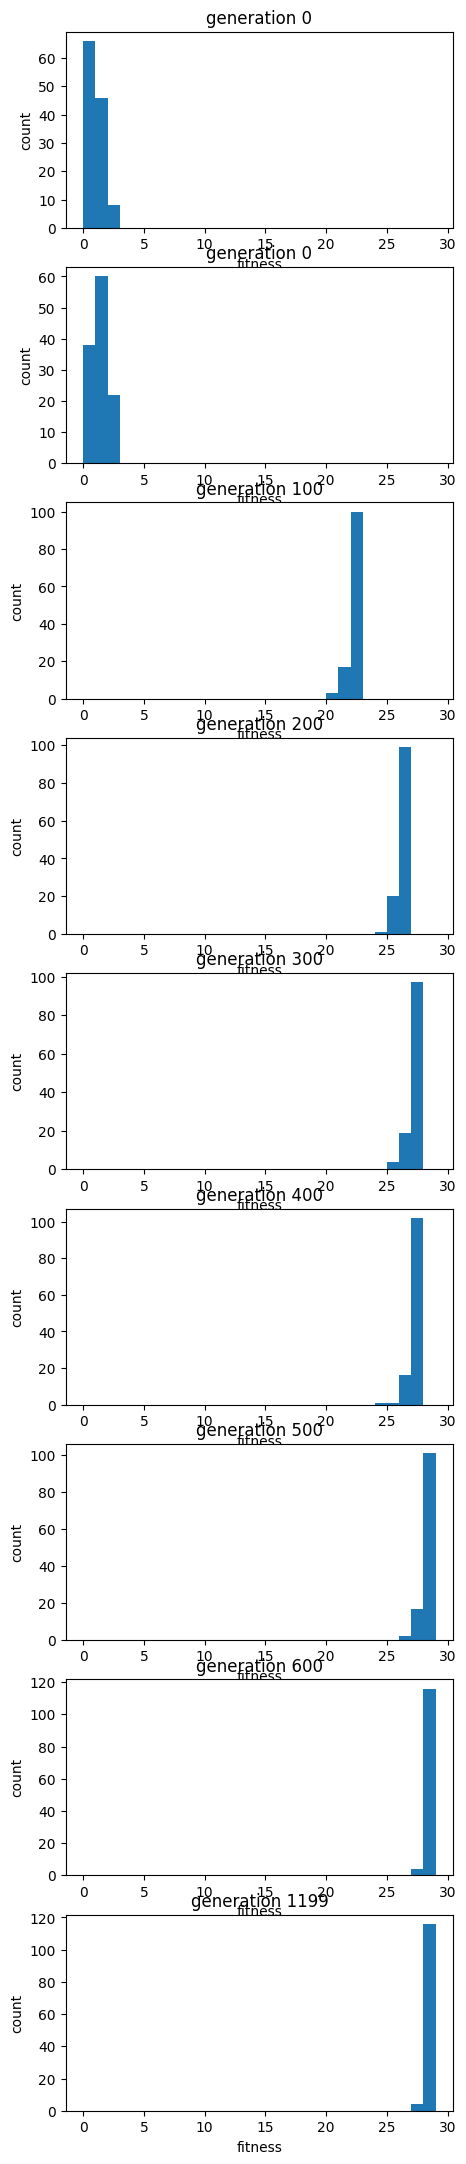

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [ ]:
# visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness+1)
plot_evolution(history, bins)
bins

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [ ]:
class NQueensProblem(GAProblem):
    def __init__(self, n, init_size):
        self.n = n
        self.max_fitness =  n*(n-1)//2 # max number if non-attacking pairs
        self.init_size = init_size

    def init_population(self, pop_size):
        # alomost the same as the previous problem.
        population = []
        for _ in range(pop_size):
            new_individual = random.sample(range(0,self.n),self.n)
            population.append(new_individual)

        return population
    
    def fitness(self, queens):
        """
        hint: count the non-attacking pairs
        """
        #每行有且只有一个，所以不用考虑行是否满足
        cnt = 0
        for i in range(self.n - 1):
            for j in range(i+1, self.n):
                if queens[j] == queens[i]:
                    cnt += 1
        for i in range(self.n - 1):
            for j in range(1,self.n - i):
                if queens[i] - j >= 0 and queens[i + j] == queens[i] - j:
                    cnt += 1
                if queens[i] + j < self.n and queens[i + j] == queens[i] + j:
                    cnt += 1
        return self.max_fitness-cnt

    def reproduce(self, population, mutation_rate):
        # alomost the same as the previous problem.
        new_population = []
        temp_parents = []
        for _ in range(int(self.init_size/2)):
            parents = self.select(2,population)
            temp_parents += parents
            child = self.mutate(self.recombine(*parents), mutation_rate)
            new_population.append(child)
        population += temp_parents
        return new_population

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        next_population = []

        for _ in range(int(self.init_size/2)):
            best = max(old, key=self.fitness)
            next_population.append(best)
            old.remove(best)
        next_population += new

        return next_population

    def select(self,r, population):
        parents = []
        for _ in range(r):
            best = max(population,key=self.fitness)
            parents.append(best)
            population.remove(best)
        return parents

    def recombine(self,x,y):
        r = random.randint(0,len(x) - 1)
        x_temp = x[r:]
        y_temp = y[r:]
        x = x[:r] + y_temp
        y = y[:r] + x_temp
        return max((x,y),key=fitness_fn)

    def mutate(self,x,pmut):
        if random.uniform(0, 1) >= pmut:
            return x
        c = random.randint(0, self.n - 1)
        return x[:c] + [random.randint(0,self.n - 1)] + x[c + 1:]

    def __repr__(self):
        return f"{self.n}-Queens Problem"


def genetic_algorithm(problem: GAProblem, ngen, n_init_size, mutation_rate, log_intervel=100):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
            if problem.fitness(best) == problem.max_fitness:
                break
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [ ]:
from utils import plot_NQueens
ngen = 1000
init_size = 50
mutation_rate = 0.8

n = 8
problem = NQueensProblem(n, init_size)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)

Generation: 0/1000,	Best: [1, 6, 4, 0, 7, 3, 5, 2],	Fitness=27
Generation: 100/1000,	Best: [1, 6, 4, 0, 7, 3, 5, 2],	Fitness=27
Generation: 200/1000,	Best: [1, 6, 4, 0, 7, 3, 5, 2],	Fitness=27
Generation: 300/1000,	Best: [1, 6, 4, 0, 7, 3, 5, 2],	Fitness=27
Generation: 400/1000,	Best: [4, 6, 1, 5, 2, 0, 3, 7],	Fitness=28


d:\000000000WPS\5Ai\lab\lab7\Practice7\utils.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


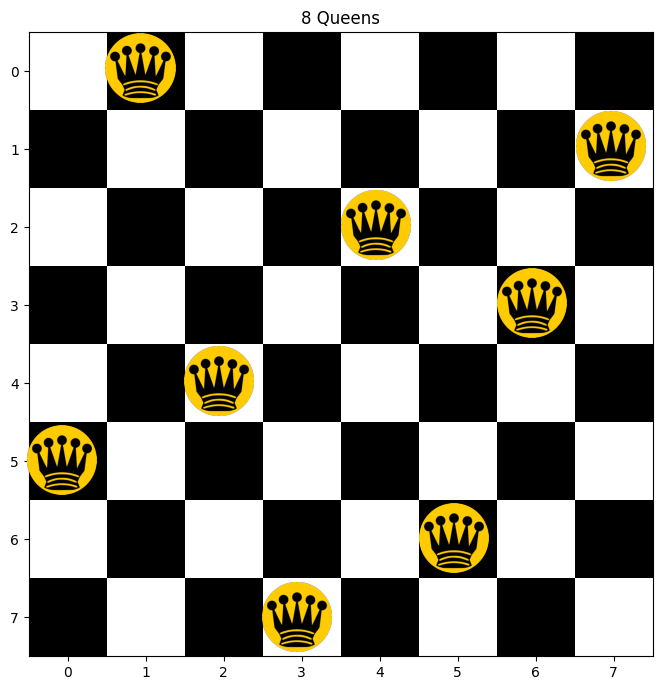

In [ ]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
plot_NQueens(solution)

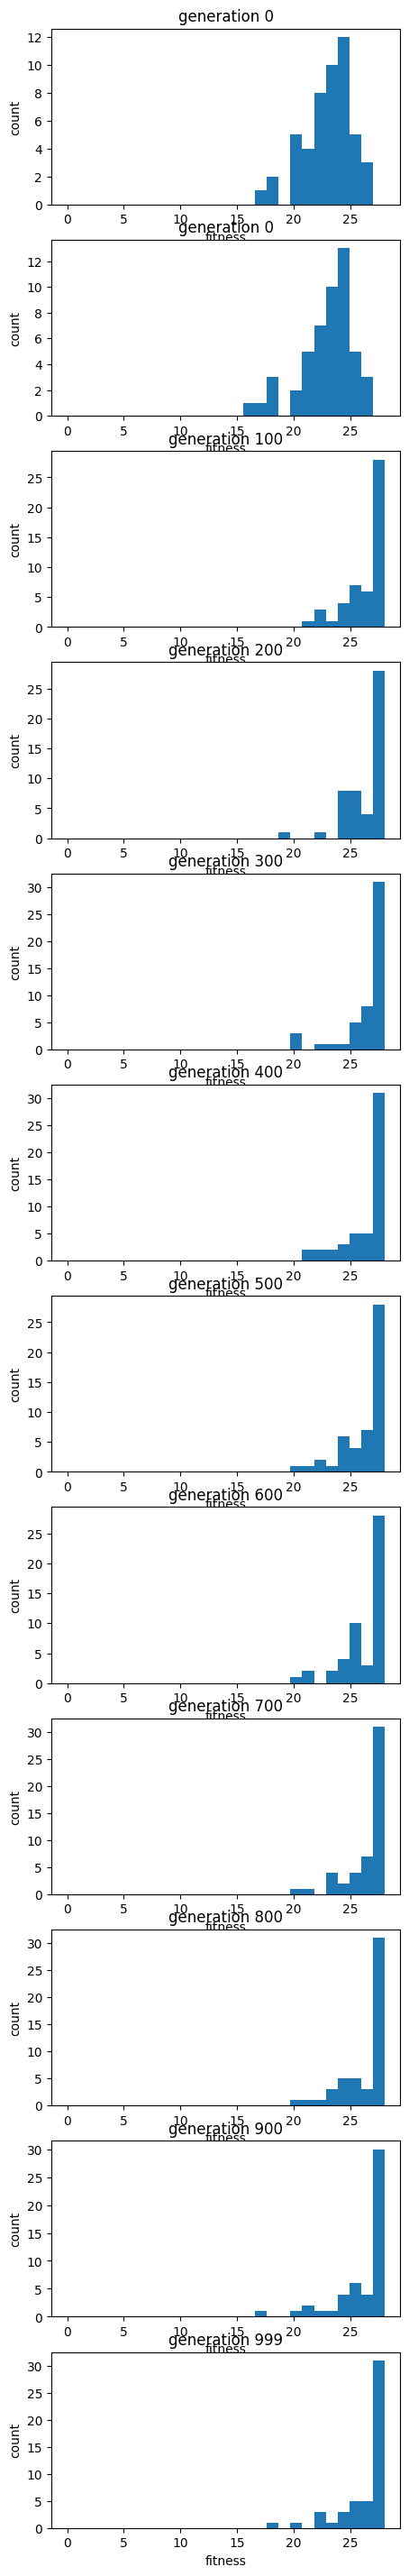

In [ ]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)